In [33]:
# This notebook tests different implicit ratings and how to obtain missing values

import pandas as pd
import numpy as np
import project_example as pe

In [34]:
# Load datasets
events = pe.load_data('active1000')
users = pd.read_csv('data/users_new_2.csv')
items = pd.read_csv('data/articles_new.csv')

In [35]:
from sklearn import preprocessing
# Impute missing activeTime values by the mean
events['activeTime'].fillna(events['activeTime'].mean(), inplace=True)

# Normalize activeTime values in a new column
scaler = preprocessing.MinMaxScaler()
events['normalized_activeTime'] = scaler.fit_transform(events['activeTime'].values.reshape(-1,1))

In [37]:
# Initiate ratings matrix
n_users = len(users)
n_items = len(items)

ratings = np.zeros((n_users, n_items))
print(f'Rating matrix shape: {n_users} x {n_items}')

Rating matrix shape: 1000 x 20344


In [71]:
def prepare_data(df):
    # Drop all documents with no ID
    df = df[~df['documentId'].isnull()]
    # Drop all duplicates of same user and document
    df = df.drop_duplicates(subset=['userId', 'documentId']).reset_index(drop=True)
    # Sort by userId and time
    df = df.sort_values(by=['userId', 'time'])
    n_users = df['userId'].nunique()
    n_items = df['documentId'].nunique()

    # Intialize ratings matrix
    ratings = np.zeros((n_users, n_items))
    # Check that there are no duplicate users
    new_user = df['userId'].values[1:] != df['userId'].values[:-1]
    # Convert to truth matrix
    new_user = np.r_[True, new_user]
    # Create new user ID: uid
    df['uid'] = np.cumsum(new_user)
    # Get all unique documents
    item_ids = df['documentId'].unique().tolist()
    # Create new dataframe with document and new document ID: tid
    new_df = pd.DataFrame({'documentId':item_ids, 'tid':range(1,len(item_ids)+1)})
    # Merge uid and tid on documentId
    df = pd.merge(df, new_df, on='documentId', how='outer')
    # Create our lookup table for interactions between users and documents
    df_ext = df[['uid', 'tid', 'normalized_activeTime']]
    # Return lookup table, empty ratings matrix and mapper to lookup documentId
    mapper = df
    return df_ext, ratings, mapper

In [72]:
df_ext, ratings, mapper = prepare_data(events)

In [46]:
def fill_ratings_matrix(df_ext, ratings):
    # Fill ratings matrix
    for row in df_ext.itertuples():
        ratings[row[1] - 1, row[2] - 1] = row[3]
    return ratings

In [47]:
ratings_active_time = fill_ratings_matrix(df_ext, ratings)
ratings_active_time

array([[0.01781737, 0.00222717, 0.00668151, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.48329621, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1403118 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04828461, ..., 0.        , 0.04828461,
        0.04828461],
       [0.07461024, 0.        , 0.04828461, ..., 0.        , 0.        ,
        0.        ]])

In [48]:
def train_test_split(ratings, fraction):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        size = int(len(ratings[user, :].nonzero()[0]) * fraction)
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=size,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
    assert(np.all((train * test) == 0))
    return train, test

In [49]:
train, test = train_test_split(ratings_active_time, fraction=0.2)

In [50]:
def evaluate(pred, actual, k):
    """
    Evaluate recommendations according to recall@k and ARHR@k
    """
    total_num = len(actual)
    tp = 0.
    arhr = 0.
    for p, t in zip(pred, actual):
        if t in p:
            tp += 1.
            arhr += 1./float(p.index(t) + 1.)
    recall = tp / float(total_num)
    arhr = arhr / len(actual)
    print("Recall@{} is {:.4f}".format(k, recall))
    print("ARHR@{} is {:.4f}".format(k, arhr))

Iteration: 1
Train mse: 0.006323658527964008
Test mse: 0.007890943124989995
Iteration: 2
Train mse: 0.005357205627003307
Test mse: 0.007751076842553662
Iteration: 5
Train mse: 0.005154705688740067
Test mse: 0.00773879694526078
Iteration: 10
Train mse: 0.0051376882591206855
Test mse: 0.007737273887664043
Iteration: 25
Current iteration: 10
Train mse: 0.005133878676546765
Test mse: 0.007734972325363
Iteration: 50
Current iteration: 10
Current iteration: 20
Train mse: 0.005133683805408927
Test mse: 0.00773448377746124
Iteration: 100
Current iteration: 10
Current iteration: 20
Current iteration: 30
Current iteration: 40
Current iteration: 50
Train mse: 0.0051330914178031855
Test mse: 0.007732548439466195


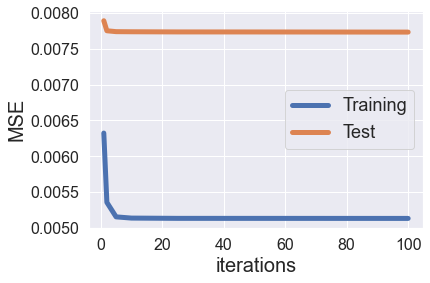

In [51]:
from ExplicitMF import ExplicitMF

model = ExplicitMF(train, n_factors=40, user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
model.calculate_learning_curve(iter_array, test)
pe.plot_learning_curve(iter_array, model)

In [ ]:
from ExplicitMF import ExplicitMF

model = ExplicitMF(train, n_factors=20)
iter_array = [1, 2, 5, 10, 25] # , 50, 100
model.calculate_learning_curve(iter_array, test)
pe.plot_learning_curve(iter_array, model)

In [52]:
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 5
Regularization: 0.01
Iteration: 1
Train mse: 0.00928381606535367
Test mse: 0.00919614814695353
Iteration: 2
Train mse: 0.0074713924941245645
Test mse: 0.0077598610090102845
Iteration: 5
Train mse: 0.007202453729419021
Test mse: 0.00753825485666459
Iteration: 10
Train mse: 0.007127709977931498
Test mse: 0.00746137043410134
Iteration: 25
Current iteration: 10
Train mse: 0.007084179556394345
Test mse: 0.0073957017675375806
Iteration: 50
Current iteration: 10
Current iteration: 20
Train mse: 0.007068766124538351
Test mse: 0.007382312693170288
Iteration: 100
Current iteration: 10
Current iteration: 20
Current iteration: 30
Current iteration: 40
Current iteration: 50
Train mse: 0.0070605027498709064
Test mse: 0.007374371269504115
New optimal hyperparameters
n_factors                                                5
reg                                                   0.01
n_iter                                                 100
train_mse                                         

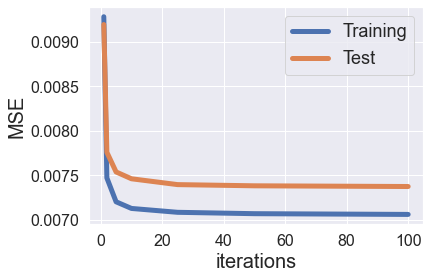

In [53]:
best_als_model = best_params['model']
pe.plot_learning_curve(iter_array, best_als_model)

In [103]:
best_params

{'n_factors': 5,
 'reg': 0.01,
 'n_iter': 100,
 'train_mse': 0.0070605027498709064,
 'test_mse': 0.007374371269504115,
 'model': <ExplicitMF.ExplicitMF at 0x372990fd0>}

In [55]:
predictions = best_als_model.predict()

In [59]:
best_als_model.user_vecs

array([[ 0.06151095,  0.01758448, -0.04733656, -0.03496622,  0.04155669],
       [-0.10089499, -0.11872518,  0.23320691,  0.21823995,  0.09114177],
       [ 0.01110613, -0.00595552, -0.00554942, -0.01199448,  0.01889704],
       ...,
       [ 0.01833016, -0.01312439,  0.00715622,  0.00320009,  0.00712018],
       [ 0.06914808, -0.01410983, -0.00363666, -0.04304837,  0.0336022 ],
       [ 0.03785728,  0.00811067,  0.01084138,  0.02410091, -0.00342805]])

In [ ]:
df_original=pe.load_data("active1000")
pe.collaborative_filtering(df_original)

In [69]:
def item_cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_item_sim = item_cosine_similarity(best_als_model)

/var/folders/bw/xj159s751_s5rj39wj1_r2900000gn/T/ipykernel_37263/1183665166.py:4: RuntimeWarning: invalid value encountered in true_divide
  return sim / norms / norms.T


In [75]:
def user_cosine_similarity(model):
    sim = model.user_vecs.dot(model.user_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_user_sim = user_cosine_similarity(best_als_model)

In [124]:
df_ext[df_ext['uid'] == 132]

,uid,tid,normalized_activeTime
23,132,1,0.032294
557,132,5,0.026726
1163,132,8,0.128062
1361,132,9,0.006682
1613,132,11,0.057906
...,...,...,...
655564,132,8221,0.123608
655567,132,8222,0.099109
655571,132,8223,0.143653
655581,132,8224,0.042316


In [70]:
def evaluate(pred, actual, k):
    """
    Evaluate recommendations according to recall@k and ARHR@k
    """
    total_num = len(actual)
    tp = 0.
    arhr = 0.
    for p, t in zip(pred, actual):
        if t in p:
            tp += 1.
            arhr += 1./float(p.index(t) + 1.)
    recall = tp / float(total_num)
    arhr = arhr / len(actual)
    print("Recall@{} is {:.4f}".format(k, recall))
    print("ARHR@{} is {:.4f}".format(k, arhr))

In [105]:
# Choose random user to recommend articles to
test_user_idx = df_ext['uid'][132]
test_article_idx = df_ext['tid'][12204]

In [96]:
def display_top_k_articles_from_item(similarity, mapper, article_idx):
    article_indices = np.argsort(similarity[article_idx, :])[::-1]
    rec_art = []
    for i in range(0, 10):
        rec_art.append(mapper[mapper['tid'] == article_indices[i]].head(1)['title'].values[0])
    return rec_art

rec_art_items = display_top_k_articles_from_item(als_item_sim, mapper, test_article_idx)

In [113]:
def display_top_k_articles_from_user(similarity, mapper, user_idx):
    user_indices = np.argsort(similarity[user_idx, :])[::-1]
    print(len(user_indices))
    return
    rec_art = []
    for i in range(0, 10):
        uids = mapper[mapper['uid'] == user_indices[i]]
        print(uids)
        break
        # If the user has already seen the article, don't add it
        if mapper[mapper['uid'] == user_idx]:
            continue
        rec_art.append(mapper[mapper['uid'] == user_indices[i]].head(1)['title'].values[0])
    return rec_art

rec_art_users = display_top_k_articles_from_user(als_user_sim, mapper, test_user_idx)

1000


In [100]:
rec_art_items

['Bussen skal være et gode for byens innbyggere, ikke en trussel',
 'Konkurs i kles- og interiørbutikk',
 'Kraftig omgangssyke stenger hotell i Ringerike',
 '- Vi bor på ei ganske tykk jordskorpe i Trøndelag',
 'Her gjerdes hotellet inn',
 'Hus fylt av skatter',
 'Tysk politi svarte nett-troll etter påkjørsel i Heidelberg',
 '- Folket i Trondheim henger to år etter Oslo',
 'Slik skal Trondheim bli gründerhovedstaden',
 'Hurtigruteskip må vaskes ned etter magesjau']

In [101]:
rec_art_users

['Norges landslagssjef ville ha russisk leder utestengt',
 'Iiiiiiiiiskaldt nyttårsbad',
 '- Dette er pinlig',
 'Her laver snøen ned',
 'Iiiiiiiiiskaldt nyttårsbad',
 'Norges landslagssjef ville ha russisk leder utestengt',
 'Eriksson kan måtte tilbakebetale etterlønn',
 'Norges landslagssjef ville ha russisk leder utestengt',
 'Kvinne omkom i ulykke på E39',
 'Norges landslagssjef ville ha russisk leder utestengt']